In [46]:
# !python -m nltk.downloader popular
# !pip install PySastrawi
# !pip uninstall tweepy
# !pip install tweepy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
from bs4 import BeautifulSoup as bs
import string, re, json, tweepy
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from numpy import array
import tqdm
from pprint import pprint

In [2]:
'''
Topik yang akan diambil adalah omicron. Seperti yang diketahui omicron adalah
varian covid yang baru. Varian ini menyebabkan jumlah covid meningkat lagi.
Sehingga banyak ketetapan yang keluar di Indonesia seperti PPKM, vaksinasi ke-3,
WFO, dan sebagainya. Maka dari itu perlu diketahui bagaimana pendapat masyarakat
terkait kemunculan covid omicron ini.
'''

'\nTopik yang akan diambil adalah omicron. Seperti yang diketahui omicron adalah\nvarian covid yang baru. Varian ini menyebabkan jumlah covid meningkat lagi.\nSehingga banyak ketetapan yang keluar di Indonesia seperti PPKM, vaksinasi ke-3,\nWFO, dan sebagainya \n'

In [3]:
# Mengakses token
with open("token.json")as f:
  tokens = json.load(f)

bearer_token = tokens['bearer_token']
api_key = tokens['api_key']
api_key_secret = tokens['api_key_secret']
access_token = tokens['access_token']
access_token_secret = tokens['access_token_secret']

auth = tweepy.OAuthHandler(api_key, api_key_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

In [6]:
# Mengambil data dari twitter
search_words = "omicron"
new_search = search_words + " -filter:retweets"

response = tweepy.Cursor(api.search_tweets,
                         q=new_search,
                         lang="id",
                         tweet_mode = "extended",
                         ).items(300)

data = [tweet.full_text for tweet in response]

In [8]:
# Mengambil data dari kompas.com dengan topik pilihan "wabah cirus corona"
for page in range(1,26):
  if page == 1:
    url = "https://www.kompas.com/topik-pilihan/list/6178/wabah-virus-corona"
  else :
    url = "https://www.kompas.com/topik-pilihan/list/6178/wabah-virus-corona?page="+str(page)
  
  page = urlopen(url)
  soup = bs(page, "html.parser")

  table = soup.find("div", {"class":"latest--news"})
  rows = table.findAll("div", {"class":"article__list"})

  for row in rows:
    for cell in row.findAll("h3"):
      data.append(cell.get_text())

In [29]:
# Membuat Data Frame dan export menjadi csv
pd.DataFrame(data, columns={"text"}).to_csv('dataset_omicron.csv', index=False)

In [3]:
# Memanggil dataset omicron dan melihat detail dari data
df = pd.read_csv("dataset_omicron.csv")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    550 non-null    object
dtypes: object(1)
memory usage: 4.4+ KB


,text
0,@clownyxxx omicron takut kali ya sm pasar lama
1,Kemenkes mengatakan sudah ada 330 kasus infeks...
2,[BEFORE AND AFTER]\nMumpung kasus penyakit Vir...
3,"Family member semua kena covid, member2 terdek..."
4,Survive covid alfa beta delta tapi tumbang kar...


In [7]:
# Menghilangkan angka, tanda baca dan whitespaces
non_angka = [re.sub(r"\d+", "", x) for x in df["text"]]
non_simbol = [x.translate(str.maketrans("","",string.punctuation)) for x in non_angka]
non_spaces = [x.strip() for x in non_simbol]

# Case Folding
case_folding = [item.lower() for item in non_spaces]

# Menghilangkan Stopwords
stop_words = set(stopwords.words("indonesian"))
stop_words.remove("bukan")  # Keperluan sentiment analysis
stop_words.remove("tidak")  # Keperluan sentiment analysis
word_token = [word_tokenize(item) for item in case_folding]
word_clean = []
for i in word_token:
  word_clean.append(" ".join([w for w in i if not w in stop_words]))

# Mengecek kata slang
word_list = [word_tokenize(x) for x in word_clean]
tweets = [word for tweet in word_list for word in tweet]
fqdist = FreqDist(tweets)
most_common_word = fqdist.most_common(100)
print(most_common_word)

[('omicron', 337), ('covid', 289), ('update', 139), ('sultra', 87), ('papua', 76), ('januari', 67), ('varian', 59), ('banten', 52), ('februari', 50), ('jabar', 50), ('jateng', 50), ('sumsel', 50), ('babel', 50), ('lampung', 50), ('sulsel', 50), ('kaltim', 49), ('kalteng', 49), ('kaltara', 49), ('gorontalo', 49), ('sulbar', 49), ('sulteng', 38), ('maluku', 38), ('malut', 38), ('barat', 38), ('vaksin', 37), ('yg', 30), ('desember', 29), ('kena', 29), ('gejala', 27), ('ya', 25), ('penyebaran', 25), ('ni', 24), ('ba', 23), ('indonesia', 22), ('siluman', 21), ('orang', 21), ('gue', 20), ('delta', 20), ('prokes', 20), ('virus', 17), ('batuk', 17), ('positif', 17), ('sakit', 17), ('china', 17), ('who', 16), ('swab', 15), ('subvarian', 15), ('masyarakat', 15), ('aja', 14), ('pemerintah', 14), ('ga', 13), ('cegah', 13), ('ppkm', 13), ('menular', 13), ('dunia', 13), ('keselamatan', 13), ('terapkan', 13), ('gak', 12), ('nya', 12), ('flu', 12), ('nak', 12), ('kota', 12), ('menekan', 12), ('kendor'

In [8]:
# Menghilangkan kata slang
slang_list = {
    "jabar" : "jawa barat",
    "jateng" : "jawa tengah",
    "sumsel" : "sumatra selatan",
    "babel" : "bangka belitung",
    "sulsel" : "sulawesi selatan",
    "kaltim" : "kalimantan timur",
    "kalteng" : "kalimantan tengah",
    "kaltara" : "kalimantan utara",
    "sulbar" : "sulawesi barat",
    "sulteng" : "sulawesi tengah",
    "malut" : "maluku utara",
    "yg" : "yang",
    "ya" : "iya",
    "ni" : "ini",
    "ba" : "",
    "gue" : "aku",
    "prokes" : "protokol kesehatan",
    "aja" : "saja",
    "ga" : "tidak",
    "gak" : "tidak",
    "nya" : "",
    "nak" : "",
    "sih" : "",
    "dah" : "",
    "jg" : "juga",
    "kalo" : "kalau",
    "udah" : "sudah",
    "tp" : "tapi",
    "vaksin" : "vaksinasi",
    "isoman" : "isolasi mandiri",
    "dr" : "dari",
    "sumatera" : "sumatra"
}

result = []
for tweet in word_clean:
  word_list_2 = []
  for word in word_tokenize(tweet):
    if slang_list.get(word):
      word = slang_list[word]
    word_list_2.append(word)
  result.append(" ".join(word_list_2))

# Menghilangkan stopwords
word_token_2 = [word_tokenize(item) for item in result]
word_clean_2 = []
for i in word_token_2:
  word_clean_2.append(" ".join([w for w in i if not w in stop_words]))

# Membuat dataframe baru
df["text_clean"] = word_clean_2
df.head()

,text,text_clean
0,@clownyxxx omicron takut kali ya sm pasar lama,clownyxxx omicron takut kali iya sm pasar
1,Kemenkes mengatakan sudah ada 330 kasus infeks...,kemenkes infeksi omicron siluman indonesia has...
2,[BEFORE AND AFTER]\nMumpung kasus penyakit Vir...,before and after mumpung penyakit virus covid ...
3,"Family member semua kena covid, member2 terdek...",family member kena covid member terdekat apeta...
4,Survive covid alfa beta delta tapi tumbang kar...,survive covid alfa beta delta tumbang omicron ...


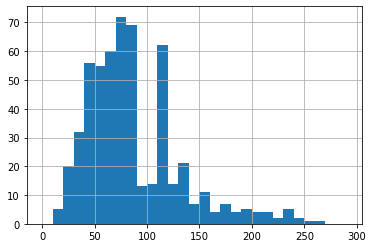

In [11]:
# Distribusi Frekuensi Karakter per Tweet
bin_range = np.arange(0, 300, 10)
df['text_clean'].str.len().hist(bins=bin_range)
plt.show()

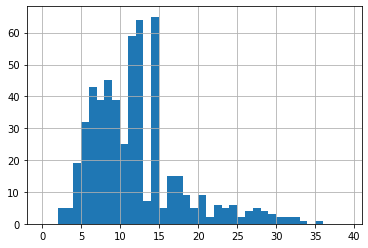

In [14]:
# Distribusi Jumlah Kata per Tweet
bin_range = np.arange(0, 40)
df['text_clean'].str.split().map(lambda x: len(x)).hist(bins=bin_range)
plt.show()

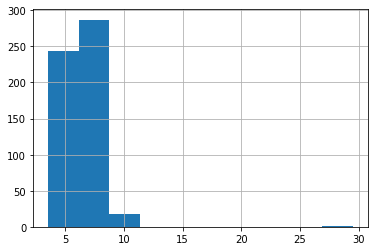

In [15]:
# Distribusi Panjang Rata - Rata Kata per Tweet
df['text_clean'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()
plt.show()

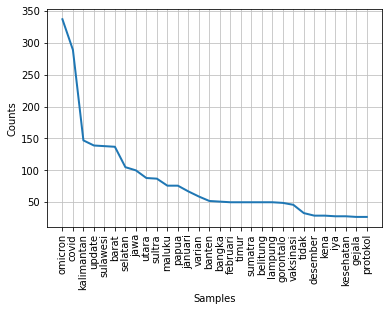

In [17]:
# Distribusi Kata
tweet_token = df["text_clean"].apply(lambda x: word_tokenize(str(x)))
tweets = [word for tweet in tweet_token for word in tweet]
fqdist_2 = FreqDist(tweets)
fqdist_2.plot(30,cumulative=False)
plt.show()

In [18]:
# Distribusi Bi-gram
bigram_result = pd.Series(nltk.ngrams(tweets, 2)).value_counts()[:20]
print(bigram_result)

(update, covid)             138
(selatan, bangka)            50
(belitung, lampung)          50
(bangka, belitung)           50
(sumatra, selatan)           50
(banten, sumatra)            50
(jawa, banten)               50
(barat, jawa)                50
(sulawesi, selatan)          50
(jawa, barat)                50
(covid, jawa)                50
(kalimantan, timur)          49
(barat, sulawesi)            49
(sulawesi, barat)            49
(gorontalo, sulawesi)        49
(utara, gorontalo)           49
(kalimantan, utara)          49
(kalimantan, kalimantan)     49
(timur, kalimantan)          49
(covid, kalimantan)          49
dtype: int64


In [48]:
# Mempersiapkan data untuk melakukan topic modelling
data_text = [text.split() for text in df["text_clean"]]

dictionary = corpora.Dictionary(data_text)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in data_text]

In [49]:
# Membuat fungsi untuk melakukan hyper tuning parameter pada model
def compute_coherence_values(corpus, dictionary, k, a, b):
    lda_model = gensim.models.LdaMulticore(corpus=doc_term_matrix,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_text, dictionary=dictionary, coherence='c_v')
    return coherence_model_lda.get_coherence()

In [50]:
# Melakukan pencarian parameter terbaik

# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(doc_term_matrix)
corpus_sets = [gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.75), 
               doc_term_matrix]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    for i in range(len(corpus_sets)):
        for k in topics_range:
            for a in alpha:
                for b in beta:
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    pbar.update(1)
    df_tuning_result = pd.DataFrame(model_results)
    pbar.close()

  0%|          | 0/540 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
100%|██████████| 540/540 [28:40<00:00,  3.19s/it]


In [51]:
df_tuning_result

,Validation_Set,Topics,Alpha,Beta,Coherence
0,75% Corpus,2,0.01,0.01,0.520313
1,75% Corpus,2,0.01,0.31,0.431837
2,75% Corpus,2,0.01,0.61,0.443295
3,75% Corpus,2,0.01,0.91,0.408889
4,75% Corpus,2,0.01,symmetric,0.438874
...,...,...,...,...,...
535,100% Corpus,10,asymmetric,0.01,0.450878
536,100% Corpus,10,asymmetric,0.31,0.375460
537,100% Corpus,10,asymmetric,0.61,0.337025
538,100% Corpus,10,asymmetric,0.91,0.328925


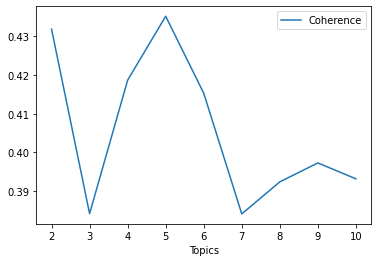

In [56]:
df_plot = df_tuning_result[(df_tuning_result.Alpha == 0.01) & (df_tuning_result.Beta == 0.31) & (df_tuning_result.Validation_Set == "100% Corpus")].copy()
df_plot.plot(x='Topics', y = "Coherence", kind="line")

In [57]:
# Berdasarkan plot, maka topik optimum sebanyak 5 topik
df_plot_2 = df_tuning_result[(df_tuning_result.Topics == 5) & (df_tuning_result.Validation_Set == "100% Corpus")].copy()
df_plot_2.sort_values(by="Coherence", ascending=False)

,Validation_Set,Topics,Alpha,Beta,Coherence
375,100% Corpus,5,0.91,0.01,0.492880
360,100% Corpus,5,0.01,0.01,0.486323
370,100% Corpus,5,0.61,0.01,0.481977
365,100% Corpus,5,0.31,0.01,0.471766
380,100% Corpus,5,symmetric,0.01,0.465773
385,100% Corpus,5,asymmetric,0.01,0.465590
362,100% Corpus,5,0.01,0.61,0.443371
381,100% Corpus,5,symmetric,0.31,0.436138
363,100% Corpus,5,0.01,0.91,0.435775
361,100% Corpus,5,0.01,0.31,0.435158


In [58]:
# Coherence value terbaik ada saat alpha 0.91 dan beta 0.01
lda_model = gensim.models.LdaMulticore(corpus=doc_term_matrix,
                                           id2word=dictionary,
                                           num_topics=5, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.91,
                                           eta=0.01)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [59]:
# Melihat kata pada setiap topik yang didapat
pprint(lda_model.print_topics())

[(0,
  '0.102*"omicron" + 0.033*"tidak" + 0.022*"gejala" + 0.018*"iya" + '
  '0.017*"anak" + 0.016*"kena" + 0.013*"batuk" + 0.012*"swab" + '
  '0.012*"isolasi" + 0.010*"cegah"'),
 (1,
  '0.065*"omicron" + 0.039*"covid" + 0.032*"inggris" + 0.028*"penyebaran" + '
  '0.028*"varian" + 0.023*"kesehatan" + 0.023*"protokol" + 0.019*"positif" + '
  '0.018*"pemerintah" + 0.016*"orang"'),
 (2,
  '0.204*"covid" + 0.149*"sulawesi" + 0.114*"selatan" + 0.093*"utara" + '
  '0.059*"desember" + 0.055*"januari" + 0.054*"timur" + 0.050*"banten" + '
  '0.033*"februari" + 0.017*"china"'),
 (3,
  '0.160*"omicron" + 0.069*"varian" + 0.035*"delta" + 0.023*"indonesia" + '
  '0.021*"who" + 0.018*"ba" + 0.017*"siluman" + 0.017*"muncul" + 0.017*"dunia" '
  '+ 0.015*"penerbangan"'),
 (4,
  '0.070*"covid" + 0.066*"vaksinasi" + 0.054*"omicron" + 0.022*"dosis" + '
  '0.021*"gelombang" + 0.020*"sakit" + 0.019*"kematian" + 0.017*"pandemi" + '
  '0.017*"tertinggi" + 0.016*"orang"')]


In [61]:
# Melakukan sentiment analysis
pos_list= open("./kata_positif.txt","r")
pos_kata = pos_list.readlines()
neg_list= open("./kata_negatif.txt","r")
neg_kata = neg_list.readlines()

last_result = []
list_anti = ['tidak','lawan','anti', 'belum', 'belom', 'tdk', 'jangan', 'gak',
             'enggak', 'bukan', 'sulit', 'tak', 'sblm']
items = word_clean_2
for item in items:
    # print(item.strip())
    tweets = item.strip().split() #tokenization
    
    count_p = 0 #nilai positif
    count_n = 0 #nilai negatif

    for tweet in tweets:
        for kata_pos in pos_kata:
            if kata_pos.strip() == tweet:
                if items[items.index(item)-1] in list_anti:
                    count_n += 1
                else:
                    count_p += 1
        for kata_neg in neg_kata:
            if kata_neg.strip() == tweet:
                if items[items.index(item)-1] in list_anti:
                    count_p += 1
                else:
                    count_n += 1
    last_result.append(count_p - count_n)

df["sentiment"] = last_result
df

,text,text_clean,sentiment
0,@clownyxxx omicron takut kali ya sm pasar lama,clownyxxx omicron takut kali iya sm pasar,-1
1,Kemenkes mengatakan sudah ada 330 kasus infeks...,kemenkes infeksi omicron siluman indonesia has...,-1
2,[BEFORE AND AFTER]\nMumpung kasus penyakit Vir...,before and after mumpung penyakit virus covid ...,-4
3,"Family member semua kena covid, member2 terdek...",family member kena covid member terdekat apeta...,0
4,Survive covid alfa beta delta tapi tumbang kar...,survive covid alfa beta delta tumbang omicron ...,-1
...,...,...,...
545,"UPDATE Covid-19 di Sulteng, Sultra, Maluku, Ma...",update covid sulawesi sultra maluku maluku uta...,0
546,WHO: Varian Omicron Lebih Menular daripada Del...,who varian omicron menular delta kurangi keman...,-1
547,"Lawan Omicron, Warga Inggris Usia 18 Tahun ke ...",lawan omicron warga inggris usia disuntik boos...,-1
548,"UPDATE Covid-19 di Kalteng, Kaltim, Kaltara, G...",update covid kalimantan kalimantan timur kalim...,0


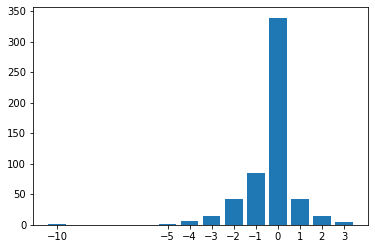

In [62]:
# Plot data kolom sentiment
labels, counts = np.unique(df["sentiment"], return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.show()

In [63]:
# Hasil Analisis

'''
Dapat diketahui bahwa mayoritas tweet atau berita berada pada 11 - 15 kata
dengan setiap kata berada diantara 5 - 8 karakter dan total 40 - 90 karakter.
Sehingga dapat disimpulkan bahwa banyak yang memberikan tanggapan tentang kasus
covid omicron.

Berdasarkan analisis bi-gram, dapat diketahui bahwa covid omicron ini terjadi di
berbagai provinsi di Indonesia. Sehingga jadi perhatian penting bagi masyarakat.
Dikarenakan pada analisis bi-gram menghasilkan banyak kata - kata tentang
provinsi, maka tidak dapat ditentukan topik yang paling banyak dibahas oleh
masyarakat. Sehingga perlu analisis lebih lanjut yaiut topic modelling.

Berdasarkan plot Coherence, maka terdapat 5 topik yang menjadi bahasan utama
oleh masyarakat. 5 topik tersebut sebagai berikut.
1. Anak - anak dapat terkena gejala omicron yaitu batuk
2. Himbauan pemerintah tentang protokol kesehatan demi mencegah penyebaran covid
   varian omicron
3. Covid omicron terjadi di sulawesi dan banten pada bulan desember sampai
   januari
4. Munculnya varian delta, omicron, dan omicron siluman di Indonesia dan Dunia
5. Covid omicron menyebabkan gelombang angka sakit dan kematian tertinggi

Berdasarkan 550 data tentang pembahasan omicron, sentimen masyarakat twitter
berada ke arah negatif dengan signifikan. Hal ini menjelaskan bahwa masyarakat
berpikiran negatif dalam menghadapi covid varian omicron. Hal ini juga dapat
disebabkan covid omicron yang menyebabkan gelombang kasus covid yang terkena
semakin tinggi, sehingga dapat membuat kepanikan bagi masyarakat. 
'''

'\nDapat diketahui bahwa mayoritas tweet atau berita berada pada 11 - 15 kata\ndengan setiap kata berada diantara 5 - 8 karakter dan total 40 - 90 karakter.\nSehingga dapat disimpulkan bahwa banyak yang memberikan tanggapan tentang kasus\ncovid omicron.\n\nBerdasarkan analisis bi-gram, dapat diketahui bahwa covid omicron ini terjadi di\nberbagai provinsi di Indonesia. Sehingga jadi perhatian penting bagi masyarakat.\nDikarenakan pada analisis bi-gram menghasilkan banyak kata - kata tentang\nprovinsi, maka tidak dapat ditentukan topik yang paling banyak dibahas oleh\nmasyarakat. Sehingga perlu analisis lebih lanjut yaiut topic modelling.\n\nBerdasarkan plot Coherence, maka terdapat 5 topik yang menjadi bahasan utama\noleh masyarakat. 5 topik tersebut sebagai berikut.\n1. Anak - anak dapat terkena gejala omicron yaitu batuk\n2. Himbauan pemerintah tentang protokol kesehatan demi mencegah penyebaran covid\n   varian omicron\n3. Covid omicron terjadi di sulawesi dan banten pada bulan desem

In [64]:
df.to_csv("result_data.csv", index=False)